# process spectra for AuxTel with new spectractor for Ronchi

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : November 22th 2021
- last update : November 2nd 2021
- version v4 : Work with new exposure format quickLookExp_v2


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Ronchi

    HD2811
    # all_myseq_ronc=range(600,630)

  

# Imports

In [77]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

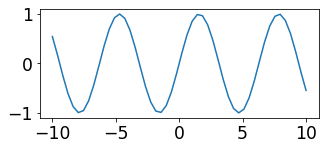

In [78]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [79]:
from iminuit import Minuit
import iminuit

In [80]:
iminuit.__version__

'2.7.0'

In [81]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [82]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [83]:
from distutils.dir_util import copy_tree
import shutil

# Configuration

In [84]:
version="v4.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

FLAG_REMOVE_WCS=False

# Path

In [85]:
# path index for each month
DATE="2021-09-09"
DATE2="2021_09_09"

In [86]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [87]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/ronchi170lpmm/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/ronchi170lpmm/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"ronchi170lpmm/quickLookExp_v2/"+DATE2)
    path_output_spectractor=os.path.join(path_auxtel,"ronchi170lpmm/OutputSpectractor/"+DATE)

# Utility Functions

In [88]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^ronchi170lpmm_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [89]:
def file_tag_forsorting_holo(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [90]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [91]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [92]:
filename_logbook='logbooks/auxtelronchilogbook_'+DATE2+'_' + version+'.csv'

In [93]:
!ls -l -t logbooks

total 416
-rw-r--r--  1 dagoret  staff   8854 Nov 22 13:28 auxtelronchilogbook_2021_09_09_v4.0.csv
-rw-r--r--  1 dagoret  staff   8815 Nov 22 13:28 auxtelronchilogbook_2021_09_09_v4.0.xlsx
-rw-r--r--  1 dagoret  staff  33562 Nov  4 12:13 auxtelholologbook_2021_07_07_v4.0.csv
-rw-r--r--  1 dagoret  staff  18608 Nov  4 12:13 auxtelholologbook_2021_07_07_v4.0.xlsx
-rw-r--r--  1 dagoret  staff  32505 Sep 30 15:11 auxtelholologbook_2021_07_07_v3.0.csv
-rw-r--r--  1 dagoret  staff  17705 Sep 30 15:11 auxtelholologbook_2021_07_07_v3.0.xlsx
-rw-r--r--  1 dagoret  staff  17706 Sep 29 13:51 auxtelholologbook_2021_07_07_v3.0_old.xlsx
-rw-r--r--  1 dagoret  staff  32505 Sep 28 16:33 auxtelholologbook_2021_07_07_v3.0_old.csv
-rw-r--r--  1 dagoret  staff   3460 Sep 23 11:49 auxtelholologbook_PNG_2021_09_09_v2.0.csv
-rw-r--r--  1 dagoret  staff   7087 Sep 23 11:49 auxtelholologbook_PNG_2021_09_09_v2.0.xlsx
-rw-r--r--  1 dagoret  staff   6782 Sep 23 11:44 auxtelholologbook_2021_07_06_v2.0.xlsx
-rw-r--

In [94]:
df=pd.read_csv(filename_logbook,index_col=0)

In [95]:
pd.set_option('display.max_rows', None)

In [96]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-09-10T06:15:30.580,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000600_qui...,600,HD2811,empty_1,ronchi170lpmm,1.028983,1.0,...,9.0,18.0,9.1,400.0,2400.0,NaN,NaN,,1.0,1.0
1,1,2021-09-10T06:15:34.147,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000601_qui...,601,HD2811,empty_1,ronchi170lpmm,1.028996,1.0,...,9.0,18.0,9.1,400.0,2400.0,NaN,NaN,,1.0,1.0
2,2,2021-09-10T06:15:37.709,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000602_qui...,602,HD2811,empty_1,ronchi170lpmm,1.029009,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
3,3,2021-09-10T06:15:41.301,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000603_qui...,603,HD2811,empty_1,ronchi170lpmm,1.029022,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
4,4,2021-09-10T06:15:44.871,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000604_qui...,604,HD2811,empty_1,ronchi170lpmm,1.029036,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
5,5,2021-09-10T06:15:48.436,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000605_qui...,605,HD2811,empty_1,ronchi170lpmm,1.029049,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
6,6,2021-09-10T06:15:51.992,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000606_qui...,606,HD2811,empty_1,ronchi170lpmm,1.029063,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
7,7,2021-09-10T06:15:55.562,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000607_qui...,607,HD2811,empty_1,ronchi170lpmm,1.029077,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
8,8,2021-09-10T06:15:59.140,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000608_qui...,608,HD2811,empty_1,ronchi170lpmm,1.029090,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
9,9,2021-09-10T06:16:02.722,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000609_qui...,609,HD2811,empty_1,ronchi170lpmm,1.029104,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [97]:
# HD 2811

In [98]:

#idx = 0 # REC failed
#idx = 1 # OK
idx = 2 # OK
idx = 3 # OK
idx = 4 # REC failed
idx = 5 # REC failed
idx = 6 # OK
idx = 7 # OK
idx = 8


In [99]:
print(df.iloc[idx]['file'])

ronchi170lpmm_empty_HD2811_20210909_000608_quickLookExp.fits


In [100]:
print(df.iloc[idx])

index                                                          8
date                                     2021-09-10T06:15:59.140
path           /Users/dagoret/DATA/AuxTelData2021/ronchi170lp...
file           ronchi170lpmm_empty_HD2811_20210909_000608_qui...
num                                                          608
object                                                    HD2811
filter                                                   empty_1
disperser                                          ronchi170lpmm
airmass                                                  1.02909
exposure                                                     1.0
focus                                                        0.0
seeing                                                  0.645059
pressure                                                   741.0
temperature                                                  9.0
humidity                                                    18.0
windspd                  

In [101]:
myhome=os.getenv("HOME")

In [102]:
dir_images=path_images

In [103]:
dir_images

'/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/quickLookExp_v2/2021_09_09'

In [104]:
filename_image=df['file'][idx]
filename_image

'ronchi170lpmm_empty_HD2811_20210909_000608_quickLookExp.fits'

In [105]:
file_target(filename_image)

'HD2811'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [106]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [107]:
FLAG_ORDER0_LOCATION=False

In [108]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

Order 0 location from logbook : (300.0,2300.0)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [109]:
filename_image.split(".")[0]

'ronchi170lpmm_empty_HD2811_20210909_000608_quickLookExp'

In [110]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09'

In [111]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_ronchi"
output_figures="figures_process_ronchi"

# Final output directory


guess = [250,2600]
disperser_label = "ronchi170lpmm"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
config="./config/auxtel_ronchi170.ini"

target = file_target(filename_image)[0]

In [112]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000608_quickLookExp'

### manage output dir

In [113]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [114]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    else:
        cleandir(output_directory)
 
    # manage subdirs spectrum/ and plots/
    if not os.path.isdir(output_figures):
        os.mkdir(output_figures)
    else:
        cleandir(output_figures)
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        #cleandir(finalpath_output_spectractor)
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

# Configuration of the Spectractor running mode

In [115]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

## Load the image in the new image file with Spectractor

In [116]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)

Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: hessian	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: hessian	 <class 'str'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> 

2021-11-22 13:54:18  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/quickLookExp_v2/2021_09_09/ronchi170lpmm_empty_HD2811_20210909_000608_quickLookExp.fits...
2021-11-22 13:54:18  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-11-22 13:54:19  Image      load_image           INFO   
	Loading disperser ronchi170lpmm...
2021-11-22 13:54:19  Hologram   load_specs           INFO   
	Load disperser ronchi170lpmm:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/ronchi170lpmm
2021-11-22 13:54:19  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 170.00 +/- 0.10 grooves/mm
	Average tilt of 0.0 degrees
2021-11-22 13:54:24  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.276136716498105 but average of self.read_out_noise is 8.5.
2021-11-22 13:54:25  Star       

In [117]:
image.data.shape

(4072, 4000)

## Show relevant parameters

In [118]:
parameters.OBS_NAME

'AUXTEL'

In [119]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [120]:
parameters.DISTANCE2CCD

182.0

In [121]:
parameters.LAMBDA_MIN 

300

In [122]:
parameters.LAMBDA_MAX 

1100

In [123]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [124]:
image.filter_label

''

In [125]:
image.header["FILTER"]

'empty_1'

In [126]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

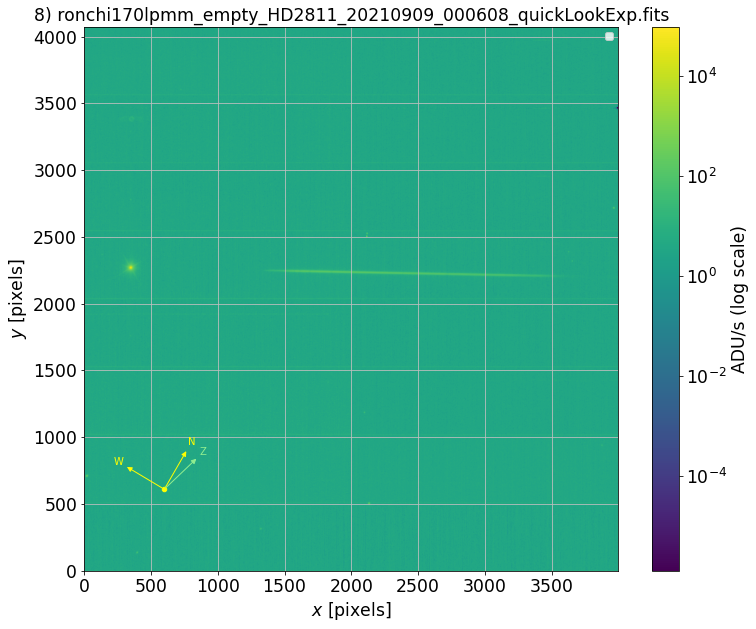

In [127]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [128]:
filename_image

'ronchi170lpmm_empty_HD2811_20210909_000608_quickLookExp.fits'

In [129]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

Set Order 0 location from logbook : (300.0,2300.0)


## Let Spectractor find the location of the 0th order

2021-11-22 13:54:31  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                c0_1        
    ------------------ ------------------- --------------------
    3.1218863893290867 0.06543322895852227 -0.03816190910218348
2021-11-22 13:54:31  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 4 iterations because the relative change of cost is below ftol=1.25e-05.


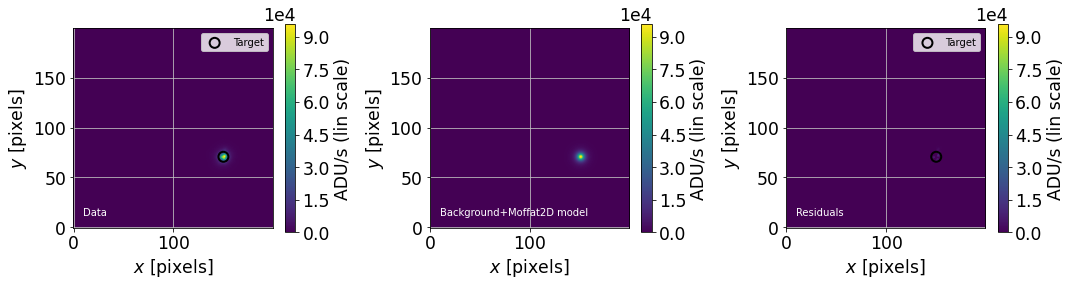

2021-11-22 13:54:32  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=5e-05.


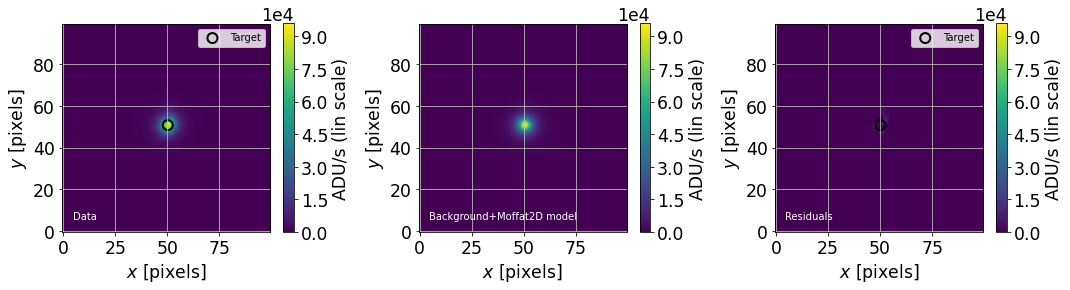

2021-11-22 13:54:33  Image      find_target          INFO   
	X,Y target position in pixels: 350.219,2270.761


In [130]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [131]:
print(x1,y1)

350.2191425938046 2270.760855594837


## Check the location of 0th order and Analysis of the quality of its focus

In [132]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [133]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [134]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [135]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [136]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [137]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [138]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [139]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [140]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [141]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [142]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [143]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [144]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

<ipython-input-145-9da0d4ef5b3f>:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle(title,Y=1.01)


Text(0.5, 1.01, '8) ronchi170lpmm_empty_HD2811_20210909_000608_quickLookExp.fits')

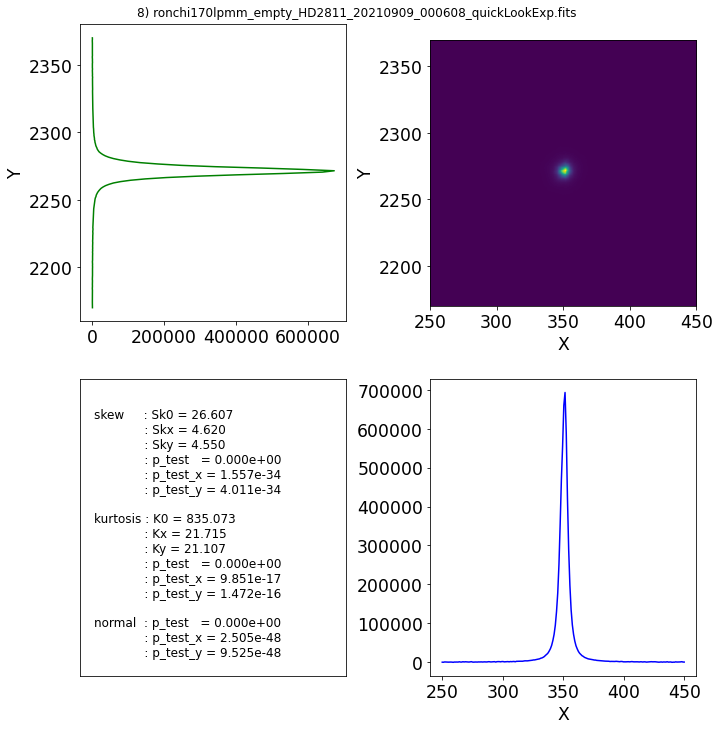

In [145]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title,Y=1.01)

In [146]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [147]:
#parameters.debug=True
#parameters.verbose=True
#parameters.display=True
#parameters.LIVE_FIT=False

In [148]:
parameters.debug=False
parameters.verbose=False
parameters.display=True
parameters.LIVE_FIT=False

In [149]:
filename

'/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/quickLookExp_v2/2021_09_09/ronchi170lpmm_empty_HD2811_20210909_000608_quickLookExp.fits'

2021-11-22 13:54:34  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: hessian	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: hessian	 <class 'str'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> 

2021-11-22 13:54:34  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/quickLookExp_v2/2021_09_09/ronchi170lpmm_empty_HD2811_20210909_000608_quickLookExp.fits...
2021-11-22 13:54:34  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-11-22 13:54:35  Image      load_image           INFO   
	Loading disperser ronchi170lpmm...
2021-11-22 13:54:35  Hologram   load_specs           INFO   
	Load disperser ronchi170lpmm:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/ronchi170lpmm
2021-11-22 13:54:35  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 170.00 +/- 0.10 grooves/mm
	Average tilt of 0.0 degrees
2021-11-22 13:54:39  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.276136716498105 but average of self.read_out_noise is 8.5.
2021-11-22 13:54:39  Star       

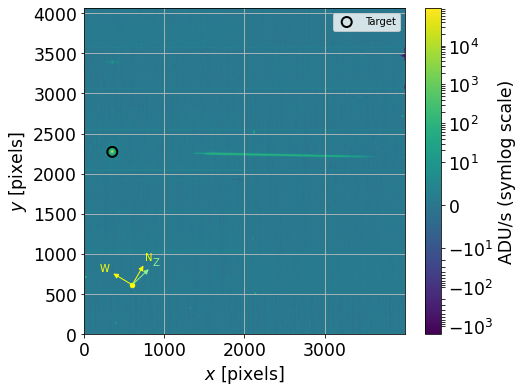

In [ ]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Backup output

In [ ]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))